In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ScipyParticle
from glob import glob
from datetime import timedelta as delta
import datetime

import glob
import os

import xarray as xr
import matplotlib.pyplot as plt
import yaml

import numpy as np
import cartopy.crs as ccrs

In [2]:
ciopse_dir='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/models/ciopse/netcdf/'
preprocess_dir='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/models/ciopse/preprocess-netcdf/shift_lon/'

# Particle initial positions

In [3]:
positions_file='/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/small-grid/mldp-winds0.0//runs/ciops-e_ml_2022022400_P2D/drifter_positions.yaml'

with open(positions_file, 'r') as f:
    positions=yaml.load(f, Loader=yaml.FullLoader)
positions = positions['drifter_grid_positions']
lons = []
lats = []
for key in positions:
    lon,lat = positions[key]
    lons.append(lon)
    lats.append(lat)

In [4]:
ufiles = sorted(glob.glob(os.path.join(preprocess_dir, '*U.nc')))
vfiles = sorted(glob.glob(os.path.join(preprocess_dir, '*V.nc')))

du = xr.open_mfdataset(ufiles)
dv = xr.open_mfdataset(vfiles)

u=np.squeeze(du.uo.values)
v=np.squeeze(dv.vo.values)
lon=du.longitude.values
lat=du.latitude.values
time=du.time_counter.values

long,latg = np.meshgrid(lon,lat)

variables = {'U': u,
             'V': v}
dimensions = {'U': {'lon': long, 'lat': latg, 'time': time},
              'V': {'lon': long, 'lat': latg, 'time': time},}


fieldset = FieldSet.from_data(variables, dimensions)
#wind_fieldset.U.set_scaling_factor(windage)

In [5]:
print(lon)

[-70.5      -70.491    -70.481995 ... -59.277893 -59.26889  -59.259888]


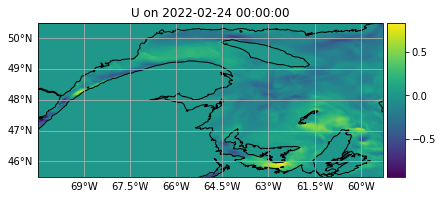

In [6]:
fieldset.U.show(domain={'N': latg.max(), 'S': latg.min(), 'E': long.max(), 'W': long.min()})

In [7]:

pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=datetime.datetime(2022,2,24),
                             depth=None)

kernels = pset.Kernel(AdvectionRK4)
output_file = pset.ParticleFile(name="ocean_parcels_preprocess.nc", outputdt=delta(hours=1))
pset.execute(kernels, runtime=delta(days=2), dt=delta(seconds=600),output_file=output_file)
output_file.close() 

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-67340/libdf57c8d10f4b0c2e13bf9a6ea2482a36_0.so


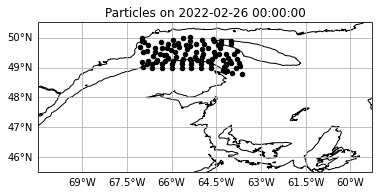

In [8]:
pset.show()

In [9]:
d = xr.open_dataset('ocean_parcels_preprocess.nc')

In [18]:
d2 = xr.open_dataset('/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/small-grid/opendrift-preprocess/output/ciops-e_od_2022022400_P2D.nc')
d3 = xr.open_dataset('/home/nso001/data/work2/OPP/mldp-opendrift-comparison/DriftMap/small-grid/mldp-winds0.0//output/ciops-e_ml_2022022400_P2D.nc')

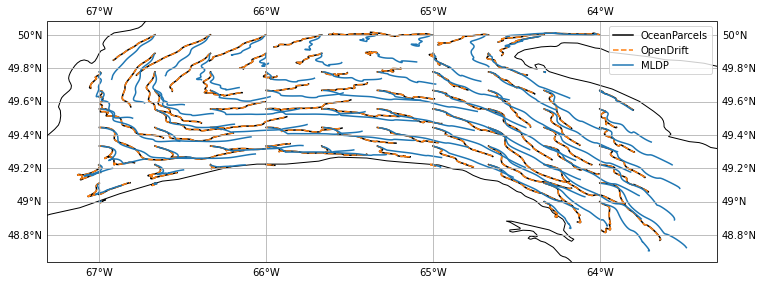

In [25]:
fig= plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
count=0
for t in range(d.trajectory.shape[0]):
    label='OceanParcels' if count==0 else '_nolabel'
    dsel=d.sel(traj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'k', label=label, transform=ccrs.PlateCarree())
    count+=1
count=0
for t in range(d2.model_run.shape[0]):
    label='OpenDrift' if count==0 else '_nolabel'
    dsel=d2.sel(model_run=t)
    ax.plot(dsel.mod_lon.values, dsel.mod_lat.values, '--C1', label=label, transform=ccrs.PlateCarree())
    count+=1
count=0
for t in range(d3.model_run.shape[0]):
    label='MLDP' if count==0 else '_nolabel'
    dsel=d3.sel(model_run=t)
    ax.plot(dsel.mod_lon.values, dsel.mod_lat.values, 'C0', label=label, transform=ccrs.PlateCarree())
    count+=1
ax.legend()
ax.coastlines()
g = ax.gridlines(draw_labels=True)
fig.savefig('OpenDriftvsOceanParcelvsMLDP-smallgrid.png', bbox_inches='tight')